# Cluster Membership Probability
### Using Extreme Deconvolution GMM with parallax as the line of sight distance information.

# Page 1

In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Cluster_analysis" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting
from Data_handling.gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train


os.chdir("Cluster_analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Cluster_analysis'

In [2]:
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)         

# 1.0 Introduction
In this section we outline a method for assigning probabilites to stars based on whether they belong to a local star cluster. Open Clusters (OCs) have been proven to be a useful tool in modern astronomy due to the homegnous nature of their parameters and a first step in performing experiments using OCs is to obtain a highly probable list of cluster members. We will begin by discussing the data we use in our model, then proceed to define the model over both astrometric and photometric features.


# 1.0.1 Global Data Preprocessing

The effectiveness of the model will depend on the quality of the data, we choose to make some global preprocessing as recommended by Lindegren et al. (2018) to account for systematic error found within the parallax and proper-motion data. In particular we exclude all stars fainer than the 18th Gaia G magnitude and make a 3-sigma clip around the median of all astrometric features.


Lindegren et al. (2018) described that a five-parameter Gaia solution is accepted only if at least six visibility periods are used so we make that cut in our data.

# 1.1 Cluster choice and data



The data used in this study was taken from the Gaia eDR3 release and the GAIA ESO iDR6. The GAIA ESO data release has identiified $n$ open clusters and provided high resolution spectrosocpy for objects within the cluster. We use the GES data sample as a highly probabalistic sample and use the range of RA and DEC to define a cone on the sky which we use to pull data from GAIA. We cross match the GAIA ESO objects with the GAIA to create a realatively small dataset with a full astrometric (including radial velocity) and photometric solution. All other objects in the GAIA cone without a cross match will be included in the training process, however during training we will utilise the our methods so that we can train over a full and partial dataset.\\

We will define two seperate models on the astrometric and photometric data. Due to the locally Gaussian nature of astrometric cluster features we expect to be able to fit a XDGMM. However, the photometric data is more complex and we will see that XDGMM or other GMM are not optimised for such features so we introduced a GMM noramlising flow to model the photometric features.

# 1.2 Astrometric solution

We begin by analysing a purely astrometric solution. We expect the cluster members' astrometric features to appear as a strong overdensity in parameter space therefore we choose to model the astrometric features using an XDGMM. This allows us to deal with erroneous and missing data.\\

To begin we let $x,y$ denote the right ascention (RA) and declination (DEC) respectively. Similarly we denote the proper motion of RA and DEC as $\mu_x, \mu_y$. Along the line of sight we let the parallax be denoted as $\omega$, the radial velocity as $v$ and the distance in parsec as $r$. Moreover $\sigma_ \alpha$ will be the error corresponding to any feature $\alpha$

In [3]:
os.chdir('../cluster_files')

In [4]:
gaia_eso=pd.read_csv('gaia_eso.csv')
gaia_not_eso=pd.read_csv('gaia_not_eso.csv')

In [5]:
os.chdir('../Cluster_analysis')

# Plot and code for Preprocessing section.


Significantly many stars have G magnitude greater than 18.

https://arxiv.org/pdf/2108.02783.pdf

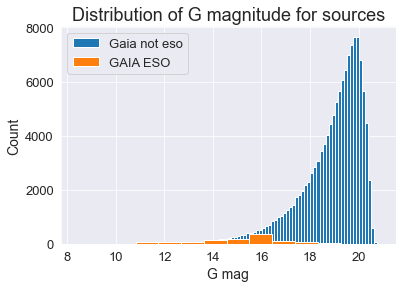

In [6]:
plt.hist(gaia_not_eso['phot_g_mean_mag'],bins=100,label='Gaia not eso')
plt.hist(gaia_eso['phot_g_mean_mag'],bins=10,label='GAIA ESO')
plt.xlabel('G mag')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of G magnitude for sources')
plt.show()

Make the cuts.

In [7]:
gaia_not_eso=gaia_not_eso[gaia_not_eso['phot_g_mean_mag']<=18.0].reset_index(drop=True)
gaia_eso=gaia_eso[gaia_eso['phot_g_mean_mag']<=18.0].reset_index(drop=True)

In [8]:
gaia_not_eso=gaia_not_eso[gaia_not_eso['visibility_periods_used']>5].reset_index(drop=True)
gaia_eso=gaia_eso[gaia_eso['visibility_periods_used']>5].reset_index(drop=True)

# Proper motion cuts

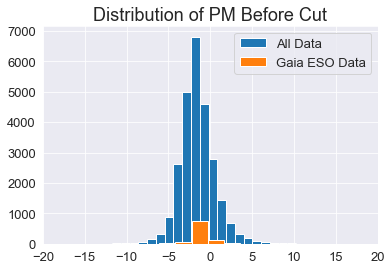

In [9]:
plt.title('Distribution of PM Before Cut')
plt.hist(gaia_not_eso['pmra'],bins=100,label='All Data')
plt.hist(gaia_eso['pmra'],bins=10,label='Gaia ESO Data')
plt.xlim(-20,20)
plt.legend()
plt.show()

Take a 5 sigma cut around the median

In [10]:
bound=[gaia_eso['pm'].median()-5*gaia_eso['pm'].std(),gaia_eso['pm'].median()+5*gaia_eso['pm'].std()]
truth1=gaia_not_eso['pm']>=bound[0]
gaia_not_eso=gaia_not_eso[truth1].reset_index(drop=True)
truth2=gaia_not_eso['pm']<=bound[1]
gaia_not_eso=gaia_not_eso[truth2].reset_index(drop=True)
len(gaia_not_eso)

25894

Do the same for the Gaia ESO sample. I hope that these have been aligned correctly.

In [11]:
truth1=gaia_eso['pm']>=bound[0]
gaia_eso=gaia_eso[truth1].reset_index(drop=True)
truth2=gaia_eso['pm']<=bound[1]
gaia_eso=gaia_eso[truth2].reset_index(drop=True)
len(gaia_eso)

995

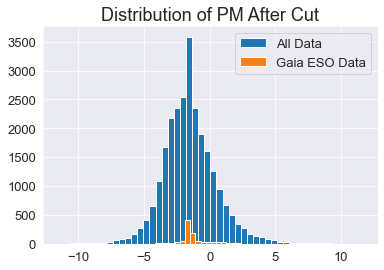

In [12]:
plt.title('Distribution of PM After Cut')
plt.hist(gaia_not_eso['pmra'],bins=50,label='All Data')
plt.hist(gaia_eso['pmra'],bins=50,label='Gaia ESO Data')
plt.legend()
plt.show()

# Parallax cut 

In order to make a cut on parallax we are going to use the median and standard deviation from the GAIA ESO sample to make our cuts on the overall sample.

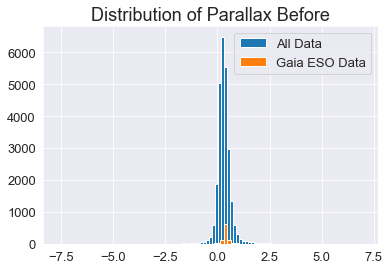

In [13]:
plt.title('Distribution of Parallax Before')
plt.hist(gaia_not_eso['parallax'],bins=100,label='All Data')
plt.hist(gaia_eso['parallax'],bins=50,label='Gaia ESO Data')
plt.legend()
plt.show()

In [14]:
np.std(gaia_eso['parallax'])

0.364649886042729

5 sigma cut

In [15]:
bound=[gaia_eso['parallax'].median()-5*gaia_eso['parallax'].std(),gaia_eso['parallax'].median()+5*gaia_eso['parallax'].std()]

In [16]:
truth1=gaia_not_eso['parallax']>=bound[0]
gaia_not_eso=gaia_not_eso[truth1].reset_index(drop=True)
truth2=gaia_not_eso['parallax']<=bound[1]
gaia_not_eso=gaia_not_eso[truth2].reset_index(drop=True)
len(gaia_not_eso)

25780

And again on the GAIA ESO one as well

In [17]:
truth1=gaia_eso['parallax']>=bound[0]
gaia_eso=gaia_eso[truth1].reset_index(drop=True)
truth2=gaia_eso['parallax']<=bound[1]
gaia_eso=gaia_eso[truth2].reset_index(drop=True)
len(gaia_eso)

991

In [18]:
len(gaia_not_eso['radial_velocity'].isna())-gaia_not_eso['radial_velocity'].isna().sum()

1971

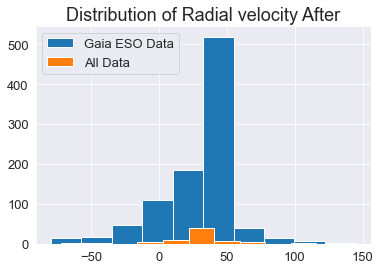

In [19]:
plt.title('Distribution of Radial velocity After')

plt.hist(gaia_eso['VRAD'],label='Gaia ESO Data')
plt.hist(gaia_eso['radial_velocity'],label='All Data')
plt.legend()
plt.show()

In [20]:
gaia_eso[gaia_eso['VRAD'].isna()!=True]['VRAD']=gaia_eso[gaia_eso['VRAD'].isna()!=True]['radial_velocity']
gaia_not_eso['VRAD']=gaia_not_eso['radial_velocity']

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_75193/485488188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaia_eso[gaia_eso['VRAD'].isna()!=True]['VRAD']=gaia_eso[gaia_eso['VRAD'].isna()!=True]['radial_velocity']


In [21]:
gaia_eso['VRAD']

0       30.64
1      105.47
2       39.07
3      -43.21
4       -5.76
        ...  
986     32.77
987     18.74
988     35.36
989      1.69
990     25.53
Name: VRAD, Length: 991, dtype: float64

# XDGMM Preprocessing

When applying the XDGMM we need not scale any features due to the likelihood approach used in the E-M algorithm. For this model however, we need to construct an error covariance matrix $S$ and a rank projection maatrix $R$ such that the observed value is related to the true value $x_i$ and the noise $\epsilon _i \sim N(0,S_i)$ by $w_i=R_ix_i + \epsilon _i$. For each $i$ the matrix $S_i$ is given in component form as $(S_i)_{jk}=\rho _{jk} \sigma_j \sigma_k$, where $\rho_{jk}$ is the correlation between the $i$ and $j^{th}$ ordered feature. These correlations if available are supplied by GAIA eDR3, if they are not available we will set them to zero. Moreover each $(R_i)_{jk}=0$ if $k\neq j$ and $(R_i)_{jj}=1$ if the observed value does not have a missing value in the $j^{th}$ feature component, and 0 otherwise.

In [22]:
columns_parameters=['ra','dec','parallax','VRAD','pmra','pmdec']

In [23]:
gaia_eso=gaia_eso[gaia_eso.replace('nan',0.0).fillna(0.0)['VRAD'].astype(float)<=300]


In [24]:

data=pd.concat([gaia_eso, gaia_not_eso])
input_cluster_data=data[columns_parameters]

(array([2.000e+00, 0.000e+00, 1.000e+00, 9.000e+00, 1.000e+02, 5.780e+02,
        1.607e+03, 5.190e+02, 1.050e+02, 7.000e+00]),
 array([-3.36863200e+02, -2.80735927e+02, -2.24608654e+02, -1.68481381e+02,
        -1.12354108e+02, -5.62268350e+01, -9.95620000e-02,  5.60277110e+01,
         1.12154984e+02,  1.68282257e+02,  2.24409530e+02]),
 <BarContainer object of 10 artists>)

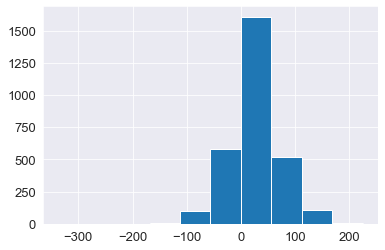

In [25]:
plt.hist(input_cluster_data['VRAD'])

We see the very strong peaks in the velocity feature space. However we do not see as strong a peak in the parallax. We will see later that this will have an effect on the design of the GMM as the peak will not be as prominant here as in the other spaces.

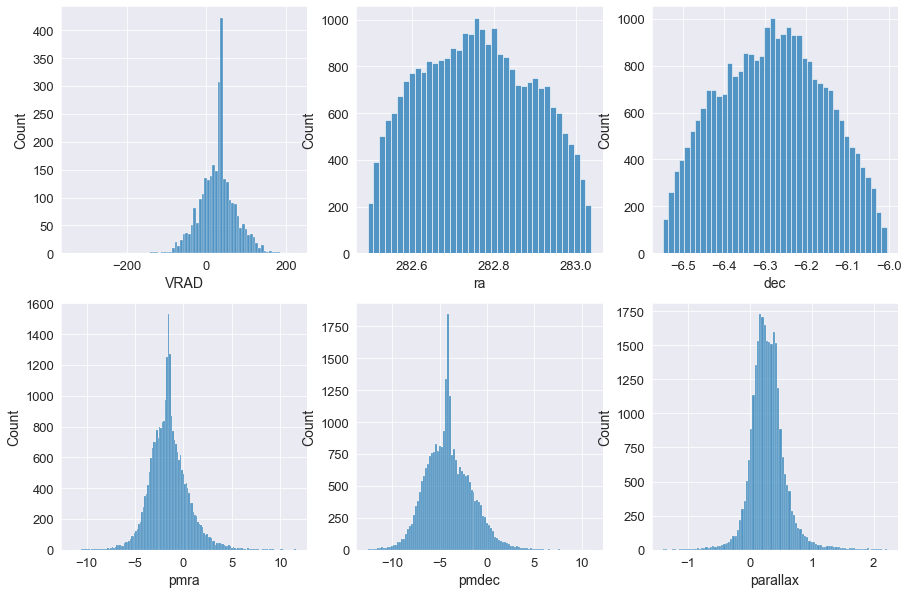

In [26]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.histplot(data=input_cluster_data['VRAD'],ax=axs[0,0],palette='pastelle')
sn.histplot(data=input_cluster_data['ra'],ax=axs[0,1])
sn.histplot(data=input_cluster_data['dec'],ax=axs[0,2])
sn.histplot(data=input_cluster_data['pmra'],ax=axs[1,0])
sn.histplot(data=input_cluster_data['pmdec'],ax=axs[1,1])
sn.histplot(data=input_cluster_data['parallax'],ax=axs[1,2],bins=100)
plt.show()


If we instead look at the Bailer Jones posterior estimates for the distances we see a more clearcut localised peak. This distance prior assumes no extinction so we will get differnet values to the cluster.

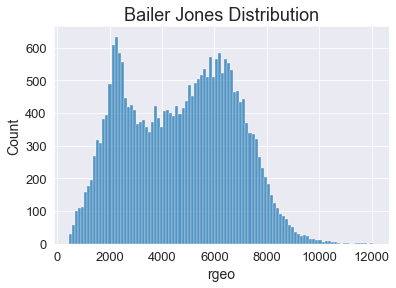

In [27]:
plt.title('Bailer Jones Distribution')
sn.histplot(data=data['rgeo'],bins=100)
plt.show()

In [28]:
columns_error=['ra_error','dec_error','parallax_error','E_VRAD','pmra_error','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr']
error_input=pd.concat([gaia_eso, gaia_not_eso])[columns_error]

# Covariance Error matrix

Our covariance error matrix is built up using the errors and correlations (if available). Correlations are available for the Gaia 5 dimensinonal astrometric solution, however the correlation for the radial velocity to other variables is not known so we will let it be zero.

In [29]:


s = np.array([[ [ None for y in range( 6 ) ] for x in range( 6 ) ] for z in range(len(error_input))])


s[:,0,0]=error_input['ra_error'].to_numpy()**2
s[:,0,1]=np.multiply(np.multiply(error_input['ra_dec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['dec_error'].to_numpy())
s[:,0,2]=np.multiply(np.multiply(error_input['ra_parallax_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['parallax_error'].to_numpy())
s[:,0,3]=0.0
s[:,0,4]=np.multiply(np.multiply(error_input['ra_pmra_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,0,5]=np.multiply(np.multiply(error_input['ra_pmdec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,1,1]=error_input['dec_error'].to_numpy()**2
s[:,1,0]=s[:,0,1]
s[:,1,2]=np.multiply(np.multiply(error_input['dec_parallax_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['parallax_error'].to_numpy())
s[:,1,3]=0.0
s[:,1,4]=np.multiply(np.multiply(error_input['dec_pmra_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,1,5]=np.multiply(np.multiply(error_input['dec_pmdec_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmdec_error'].to_numpy())




s[:,2,0]=s[:,0,2]
s[:,2,1]=s[:,1,2]
s[:,2,2]=error_input['parallax_error'].to_numpy()**2
s[:,2,3]=0.0
s[:,2,4]=np.multiply(np.multiply(error_input['parallax_pmra_corr'].to_numpy(),error_input['parallax_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,2,5]=np.multiply(np.multiply(error_input['parallax_pmdec_corr'].to_numpy(),error_input['parallax_error'].to_numpy()),error_input['pmdec_error'].to_numpy())


s[:,3,0]=0.0
s[:,3,1]=0.0
s[:,3,2]=0.0
s[:,3,3]=error_input['E_VRAD'].astype(float).to_numpy()**2 
s[:,3,4]=0.0
s[:,3,5]=0.0


s[:,4,0]=s[:,0,4]
s[:,4,1]=s[:,1,4]
s[:,4,2]=s[:,2,4]
s[:,4,3]=s[:,3,4]
s[:,4,4]=error_input['pmra_error'].to_numpy()**2
s[:,4,5]=np.multiply(np.multiply(error_input['pmra_pmdec_corr'].to_numpy(),error_input['pmra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,5,0]=s[:,0,5]
s[:,5,1]=s[:,1,5]
s[:,5,2]=s[:,2,5]
s[:,5,3]=s[:,3,5]
s[:,5,4]=s[:,4,5]
s[:,5,5]=error_input['pmdec_error'].to_numpy()**2


# Mixing Matrix R 

In order to unitilise the XDGMM we introduce a mixing matrix for each datapoint. That is, we want a matrix $R_i$ such that given an observation with missing values $w_i$ the true observation can be modelled as $w_i=R_ix_i$. Our form of the matrix is very simple, a diagonal matrix with $1$ along the $n^{th}$ diagonal if the $n^{th}$ feature was measured, and $0$ if not measured.

In [30]:
mixing_prep=(input_cluster_data.astype(str).to_numpy()!='nan').astype(int)


In [31]:
R = [] #mixing matrix
for i in range(0,len(mixing_prep)):
    R.append(np.diag(mixing_prep[i]))

R=np.array(R)
R.shape

(26771, 6, 6)

# Definitions of the learning inputs
In the preparation for making the data learning ready, we will all NaN values with 0. This is not an issue as our XDGMM will overlook these missing values anyway. In the covariance matrix if there are any NaN values we change it to a number very close to zero so that we do not run into invertability issues.

In [32]:
learning_input=input_cluster_data.replace('nan',0.0).fillna(0.0).to_numpy().astype(float)
learning_error_covariance=np.nan_to_num(s.astype(float),nan=0.0001)
  #this is so not to get singular matrix
#learning_error_covariance=np.nan_to_num(s.astype(float),nan=1e16)
learning_R=R


# 2.0 Cluster Membership Probability.

https://arxiv.org/pdf/0905.2979v2.pdf



Letting $\theta=(\alpha_j,\mu_j,V_j)$ be the parameters for a Gaussian mixture model. Following the paper above we can show that the likelihood of $\textbf{w}_i$ in terms of $\theta$ is the Gaussian mixture model: $$p(\textbf{w}_i|\theta)=\sum_j \alpha_j N(\textbf{w}_i|R_i\mu_j,T_{ij})$$
where $$T_{ij}=R_iV_jR_i^t+S_i$$

In [33]:
os.getcwd()
os.chdir('../')
from Density_estimation.xdeconv import XDGMM
os.chdir('Cluster_analysis')

We fit as per the above paper and use their E-M update algorithm. GMM returns the maximum likelihood values for the gaussian mixture parameters.

One part uses all the GES data and other uses both Gaia eso and gaia.

# Fit

We now fit our XDGMM to our data in order to assign membership probabilities. We fit our model to the data in two different ways. The first is to fit the model only to the GAIA Eso model and then evaluate the probabilities on the rest of the dataset. Our second is training our model on the full dataset and then evaluating the prbabilities simulataneously.

We use a two step process to find the best number of components in our XDGMM, we fit for numerous number of components and then evaluate the BIC. The next step is to manually check to see if the model has captured the key dependencies in velocity space. We then choose the model with the highest BIC which captures the overdensity in velocity space.

We first fit our model to the GAIA ESO data.

In [34]:
gmm_GES=XDGMM(2).fit(learning_input[0:len(gaia_eso)],Xerr=learning_error_covariance[0:len(gaia_eso)],R=R[0:len(gaia_eso)])


We find the best fit of the model evaluated on the full dataset is a XDGMM with four components.


In [35]:

gmm_full=XDGMM(4).fit(learning_input,Xerr=learning_error_covariance,R=R)

# Evaluating the Joint Probability $P(z,\textbf{w}_i)$

Our goal now is to assign a membership probability for each star, we define this as follows:
Let $z \in \{0,...,k\}$ be the random variable of deciding the probability of belonging to a component of the Gaussian Mixture.   
We have $$p(z,\textbf{w}_k|\theta)=p(z)p(\textbf{w}_k|z,\theta)$$
We can then find the posterior density function for $z$: $$p(z=i|\textbf{w}_k,\theta)={p(z=i|\theta)p(\textbf{w}_k|z=i,\theta)\over \sum_j p(z=j|\theta)p(\textbf{w}_k|z=j,\theta)}$$
We have $p(z=i|\theta)=\alpha_i$ are the mixing probabilities.

This amounts to letting the cluster likelihood $\phi _c(x)$ be the component of the Gaussian mixture model which has the highest overdensity in feature space, times the mixing probability. Moreover the field likelihood $\phi _f(x)$ is the sum of the remaining components of the GMM multiplied by their mixing probabilities. Thus our cluster membership probability is 
\begin{equation}
    \phi _c(\textbf{w}_k)\over \phi _c(\textbf{w}_k) + \phi _f(\textbf{w}_k)
\end{equation}


# GAIA ESO Train and evaluate.

### We first consider when the model was trained only on GAIA ESO data.

In [36]:

prob_ges=gmm_GES.prob_z_given_w(learning_input[0:len(gaia_eso)],Xerr=learning_error_covariance[0:len(gaia_eso)],R=R[0:len(gaia_eso)])

We plot the parameter space, darker dots correspond to higher probability of assignment.

In [37]:
df=pd.DataFrame(learning_input[0:len(gaia_eso)],columns=columns_parameters)
df2=pd.DataFrame(prob_ges[:,0][0:len(gaia_eso)],columns=['prob'])
plot_df_ges=pd.concat([df,df2],axis=1)

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

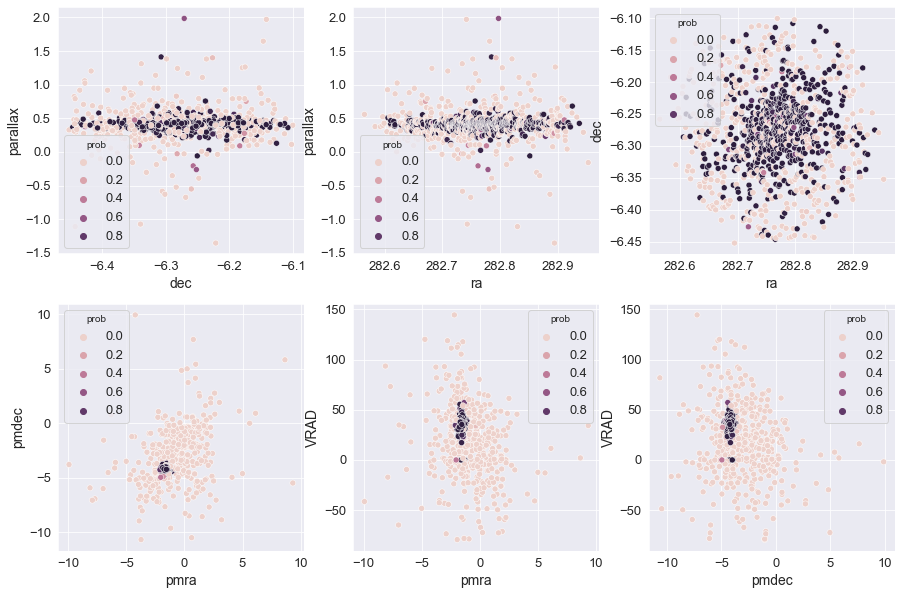

In [38]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df_ges,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df_ges,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df_ges,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df_ges,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df_ges,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df_ges,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# GAIA ESO + GAIA

We now train a different model on the whole of the dataset.

In [39]:

prob_full=gmm_full.prob_z_given_w(learning_input,Xerr=learning_error_covariance,R=R)
df=pd.DataFrame(learning_input,columns=columns_parameters)

In [47]:
df2=pd.DataFrame(prob_full[:,3],columns=['prob'])
plot_df_full=pd.concat([df,df2],axis=1)

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

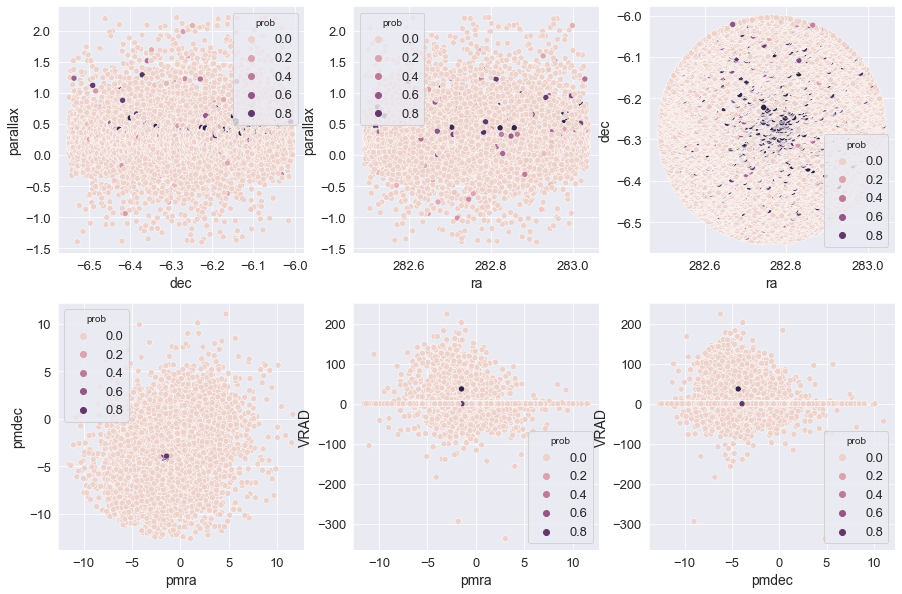

In [48]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df_full,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df_full,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df_full,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df_full,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df_full,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df_full,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])


# 2.2 Train on Gaia ESO and evaluate on GAIA plus GAIA ESO

We now see what happens if we train on a 'good' sample, that being the GAIA ESO and then apply to a much larger data set, with also less information attached to it.

In [49]:

comp=gmm_GES.prob_z_given_w(learning_input,Xerr=learning_error_covariance,R=R)
df=pd.DataFrame(learning_input,columns=columns_parameters)
df2=pd.DataFrame(comp[:,0],columns=['prob'])
plot_df=pd.concat([df,df2],axis=1)

Now we see this evaluated on our full dataset.

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

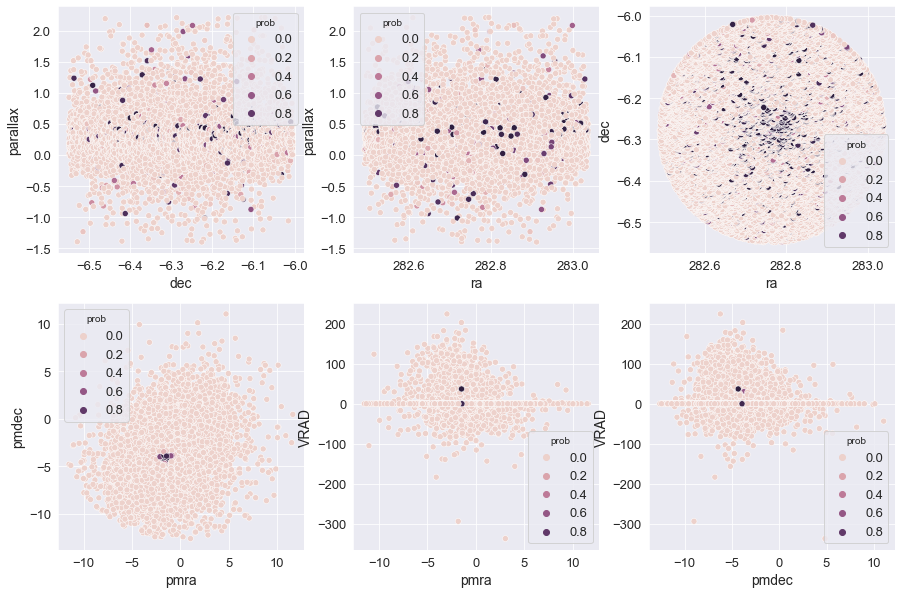

In [50]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

Now we evaluate it only on the GAIA data

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

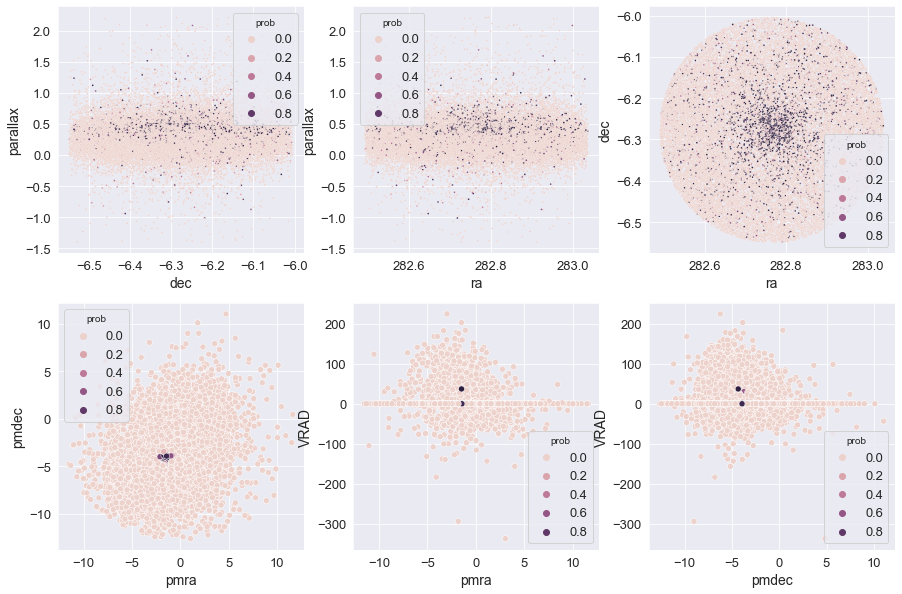

In [51]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df[len(gaia_eso):],x='dec',y='parallax',hue='prob',ax=axs[0,0],s=3)
sn.scatterplot(data=plot_df[len(gaia_eso):],x='ra',y='parallax',hue='prob',ax=axs[0,1],s=3)
sn.scatterplot(data=plot_df[len(gaia_eso):],x='ra',y='dec',hue='prob',ax=axs[0,2],s=3)

sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# Commentary on The Parameter Clustering

So far we see the overdensity in parameter space, which is promising considering our previous remarks. To further understand which stars are being classified as highly probable we look at a HR diagram and the parameter distributions of highly likely stars.

## Here we are going to analyse the HR diagrams

We begin with an analysis of the HR diagram. We expect stars to follow a main sequence pattern with break off.

https://www.aanda.org/articles/aa/pdf/2018/08/aa32843-18.pdf

In [52]:
def mean_basolute_mag_g_band(selection_gaia):

    selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-5*np.log10(selection_gaia['rgeo'])+5
    return selection_gaia

def mean_basolute_mag_g_band_parallax(selection_gaia):

    selection_gaia['mean_absolute_mag_g_band_p']=selection_gaia['phot_g_mean_mag']+5*np.log10(selection_gaia['parallax']*0.001)+5
    return selection_gaia

In [53]:
df_diagram=pd.concat([plot_df.reset_index(),data.reset_index()],axis=1)
df_diagram_full=pd.concat([plot_df_full.reset_index(),data.reset_index()],axis=1)

In [54]:
df_diagram_full = df_diagram_full.loc[:,~df_diagram_full.columns.duplicated()]
df_diagram = df_diagram.loc[:,~df_diagram.columns.duplicated()]

In [55]:
mean_basolute_mag_g_band(df_diagram)
mean_basolute_mag_g_band(df_diagram_full)

,index,ra,dec,parallax,VRAD,pmra,pmdec,prob,level_0,Unnamed: 0,...,RA_ICRS,DE_ICRS,rgeo,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,Flag,mean_absolute_mag_g_band
0,0,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839,4.570171e-108,0,0,...,282.565031,-6.258065,1942.98157,1618.71545,2489.67163,1923.29565,1666.32056,2345.46167,10033,5.377983
1,1,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347,2.212984e-100,1,1,...,282.583418,-6.192254,6141.48389,3163.27856,10115.85840,3446.87402,2693.09326,5311.75977,10033,3.868623
2,2,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,9.409423e-06,2,3,...,282.592885,-6.329504,2671.46338,2193.52368,3324.61035,2677.84912,2291.58057,3349.83423,10033,4.753740
3,3,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,3.336767e-295,3,4,...,282.596724,-6.241452,1887.64343,1726.50842,2108.31055,1788.85913,1661.42944,1947.09448,10033,4.844798
4,4,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,5.919339e-50,4,5,...,282.596739,-6.257442,2360.14062,2176.29297,2672.13403,2255.69653,2041.00903,2474.74609,10033,4.017714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26766,26766,282.788470,-6.007469,0.030766,0.00,-2.850967,-5.665195,5.106458e-30,25775,129557,...,282.788470,-6.007469,7084.01074,4910.56494,9565.59473,6045.83057,4184.62695,8731.06445,10033,3.015978
26767,26767,282.780248,-6.007047,0.449862,0.00,1.577184,3.119071,0.000000e+00,25776,129559,...,282.780248,-6.007047,2100.93555,1883.03979,2459.72168,2147.17578,1872.23279,2423.75122,10033,4.919543
26768,26768,282.775456,-6.005157,0.002803,0.00,-1.806624,-4.939151,2.667322e-07,25777,129565,...,282.775456,-6.005157,7769.46533,5965.04639,11243.42680,10565.55080,5788.68164,16626.45700,10133,2.587664
26769,26769,282.703295,-6.011748,0.209325,0.00,-3.147602,-4.699169,8.071454e-19,25778,129567,...,282.703295,-6.011748,4963.53955,3545.60669,6594.21533,3321.26025,2547.17358,4331.92773,10033,3.746492


In [56]:
data_for_hr1=df_diagram[df_diagram['prob']>=0.9]
data_for_hr2=df_diagram[df_diagram['prob']<0.9]

## Model Trained on Only GAIA ESO
The first model we show is the one which was trained only on the GAIA ESO sample and then evaluated at all points.

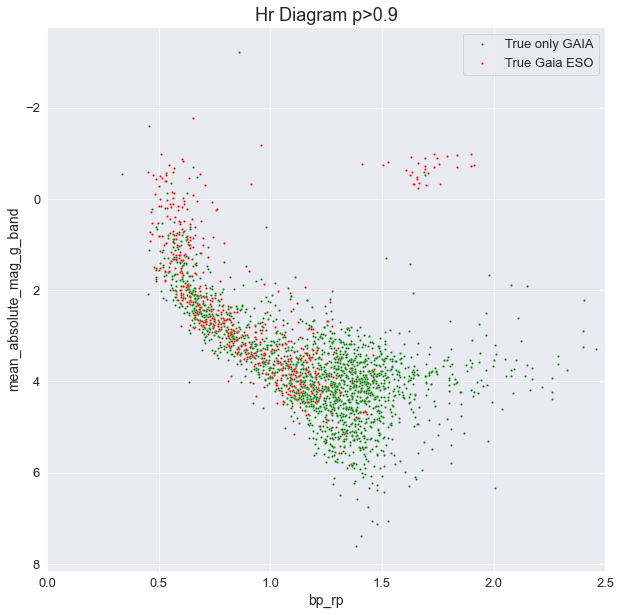

In [57]:

f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=data_for_hr1[data_for_hr1['VRAD']==0.00]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True only GAIA',s=5,color='g')

scatter=data_for_hr1[data_for_hr1['VRAD']!=0.00]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True Gaia ESO',s=5,color='r')

scatter=data_for_hr2
#sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='False',s=15,alpha=0.7)

axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("Hr Diagram p>0.9")
plt.show()

We see that this is a good start, that the XDGMM has learned some key features of the OC and this is reflected in the HR diagram. However, there is some dispersion towards the tail of the main sequence. To understand what is happening here we look at the distribtuion of parameters which have been classified.

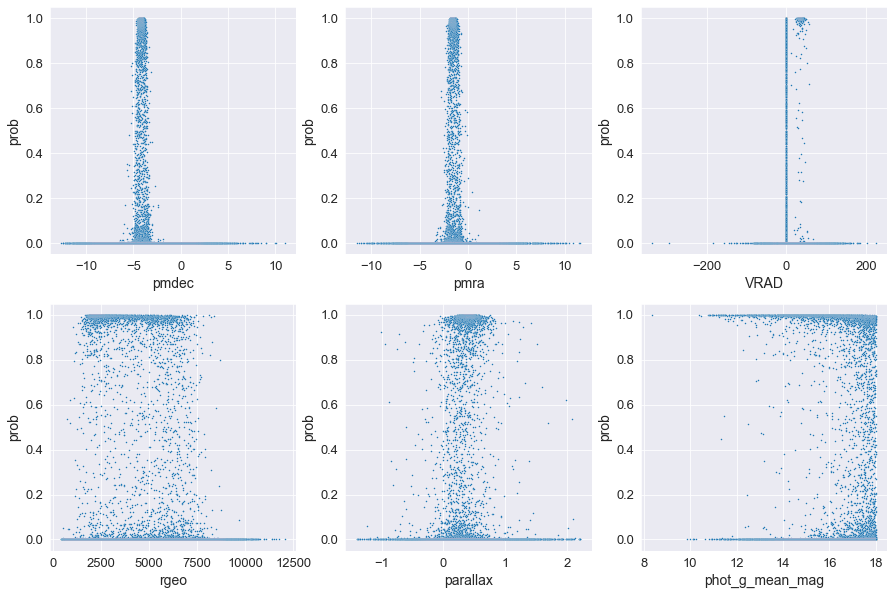

In [58]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)

cfplot=df_diagram.sort_values(by='pmdec')
sn.scatterplot(x=cfplot['pmdec'],y=cfplot['prob'],s=2.5,ax=axs[0,0])

cfplot=df_diagram.sort_values(by='pmra')
sn.scatterplot(x=cfplot['pmra'],y=cfplot['prob'],s=2.5,ax=axs[0,1])

cfplot=df_diagram.sort_values(by='VRAD')
sn.scatterplot(x=cfplot['VRAD'],y=cfplot['prob'],s=2.5,ax=axs[0,2])

cfplot=df_diagram.sort_values(by='rgeo')
sn.scatterplot(x=cfplot['rgeo'],y=cfplot['prob'],s=2.5,ax=axs[1,0])

cfplot=df_diagram.sort_values(by='parallax')
sn.scatterplot(x=cfplot['parallax'],y=cfplot['prob'],s=2.5,ax=axs[1,1])

cfplot=df_diagram.sort_values(by='phot_g_mean_mag')
sn.scatterplot(x=cfplot['phot_g_mean_mag'],y=cfplot['prob'],s=2.5,ax=axs[1,2])

plt.show()

Importantly, this doesn't seem to be able to capture the distance information. The information we have supplied the XDMM does not seem to be adequate enough to capture the relative invariance of the distance in open clusters.


# GAIA + GAIA ESO Train

We next look at how our model trained on the full dataset performs, and then compare to what we have alrady seen.

In [59]:
p=0.9
data_for_hr1_full=df_diagram_full[df_diagram_full['prob']>=p]
data_for_hr2_full=df_diagram_full[df_diagram_full['prob']<p]

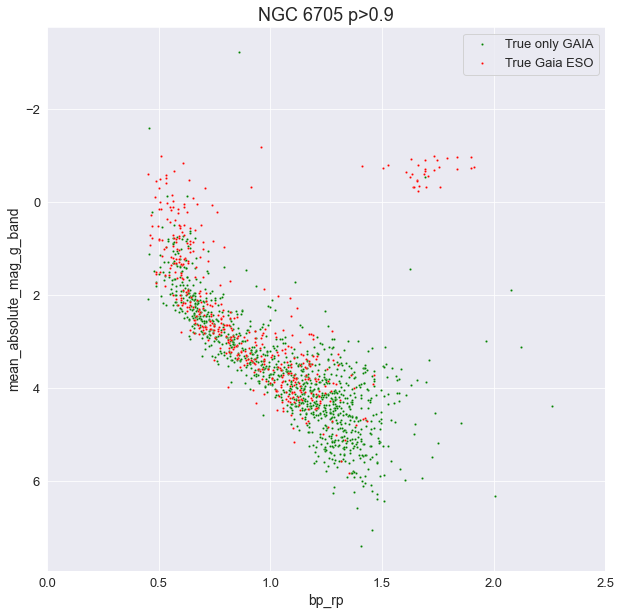

In [60]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=data_for_hr1_full[data_for_hr1_full['VRAD']==0.00]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True only GAIA',s=5,color='g')

scatter=data_for_hr1_full[data_for_hr1_full['VRAD']!=0.00]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True Gaia ESO',s=5,color='r')

scatter=data_for_hr2_full
#sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='False',s=5,alpha=0.7)

axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

This is looking a small bit better, with less dispersion towards the end of the main sequence. Include the plot here from the bottom of this page to say how the two models compare and this one seems to be better.

We now look at what information is found by the probabilities.

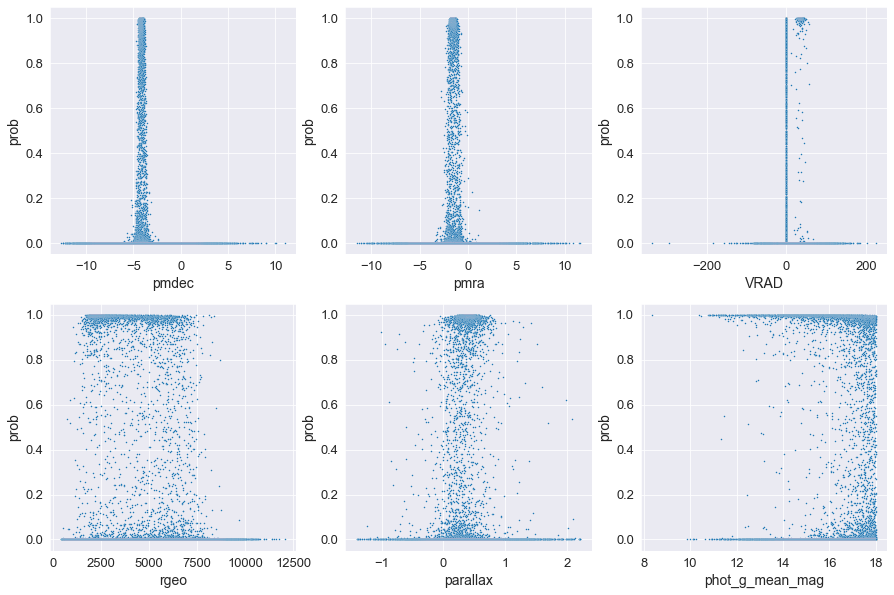

In [61]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)

cfplot=df_diagram_full.sort_values(by='pmdec')
sn.scatterplot(x=cfplot['pmdec'],y=cfplot['prob'],s=2.5,ax=axs[0,0])

cfplot=df_diagram.sort_values(by='pmra')
sn.scatterplot(x=cfplot['pmra'],y=cfplot['prob'],s=2.5,ax=axs[0,1])

cfplot=df_diagram.sort_values(by='VRAD')
sn.scatterplot(x=cfplot['VRAD'],y=cfplot['prob'],s=2.5,ax=axs[0,2])

cfplot=df_diagram.sort_values(by='rgeo')
sn.scatterplot(x=cfplot['rgeo'],y=cfplot['prob'],s=2.5,ax=axs[1,0])

cfplot=df_diagram.sort_values(by='parallax')
sn.scatterplot(x=cfplot['parallax'],y=cfplot['prob'],s=2.5,ax=axs[1,1])

cfplot=df_diagram.sort_values(by='phot_g_mean_mag')
sn.scatterplot(x=cfplot['phot_g_mean_mag'],y=cfplot['prob'],s=2.5,ax=axs[1,2])

plt.show()

Again it still cannot understand the distance information, we recall that when we analysed the parallax that we could not see this overdensity very easily, however we could in the Bailer Jones estimates. We now choose to build the model based on using these instead of parallax and compare to see the results.

Finally let us check the HR diagram with distance on it.

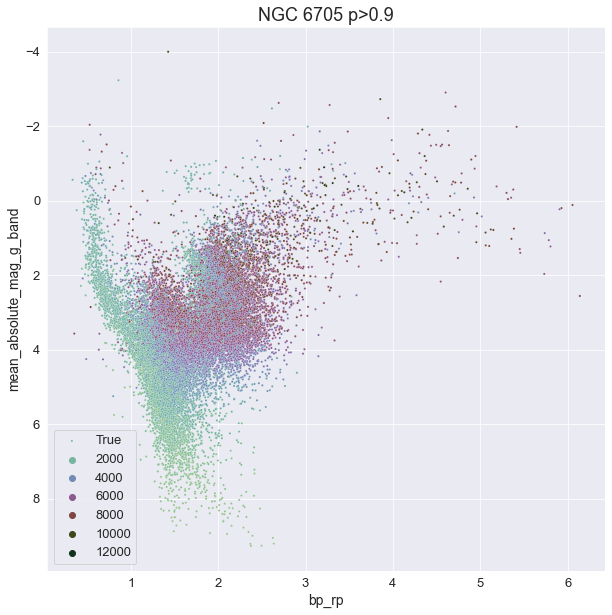

In [62]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=df_diagram#[df_diagram_full['prob']>0.9]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter['rgeo'],ax=axes,s=5,label='True',palette="ch:r=-2,l=.7")


axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

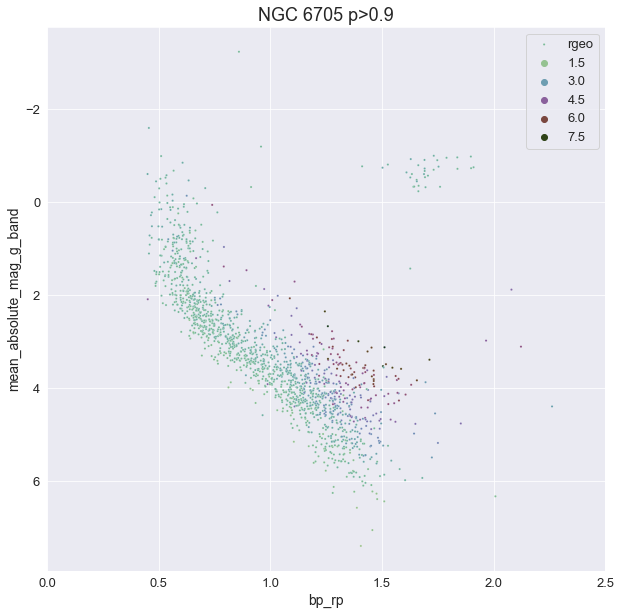

In [63]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=df_diagram[df_diagram_full['prob']>0.9]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter['rgeo']/1000,ax=axes,s=5,label='rgeo',palette="ch:r=-2,l=.7")


axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

So we can see it is not capturing the distance estimate as well as we would like.

What percentage of correct data is from GAIA only:

In [64]:
len(data_for_hr1_full[data_for_hr1_full['VRAD']==0.00])/(len(data_for_hr1_full[data_for_hr1_full['VRAD']==0.00])+len(data_for_hr1_full[data_for_hr1_full['VRAD']!=0.00]))

0.7050955414012738

# Let us now check a comparison of the two trained models:

In [65]:
df_diagram_full['prob_other']=df_diagram['prob']

In [66]:
data_for_hr1=df_diagram_full[df_diagram_full['prob']>=0.9]
data_for_hr1both=data_for_hr1[data_for_hr1['prob_other']>=0.9]
data_for_hr2=df_diagram_full[df_diagram_full['prob_other']>=0.9]
data_for_hr2=data_for_hr2[data_for_hr2['prob']<0.9]

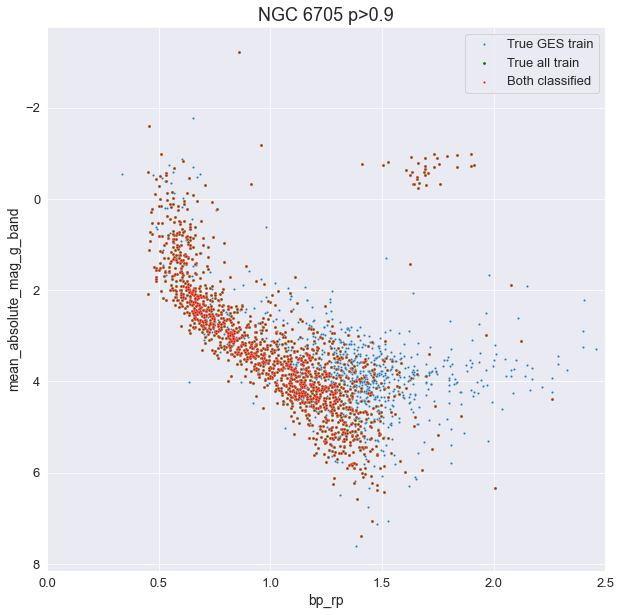

In [67]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)




scatter=data_for_hr2
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True GES train',s=5)

scatter=data_for_hr1
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,label='True all train',color='green')



scatter=data_for_hr1both
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=5,label='Both classified',color='r')


axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

# Try with RGEO instead of Parallax to see if any better.

# Saving FILES

https://arxiv.org/pdf/1405.4895.pdf

Plotting the parameters vs the expected values.

Saving files



In [68]:
data_for_colour=df_diagram_full#[['bp_rp','mean_absolute_mag_g_band','prob','ra','dec','parallax','VRAD','pmra','pmdec','phot_g_mean_mag','bp_g','g_rp','rgeo']]

In [69]:
os.chdir('../cluster_files')
data_for_colour.to_csv('vae_data.csv')
